In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_forecast_component
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.0f}'.format)

In [2]:
# importing the data

sales_data = pd.read_csv('cleaned_sales_data.csv')
prod_prices = pd.read_csv('Producer_Prices.csv')
mat_prices = pd.read_csv('Prices_of_Materials.csv')
prod_index = pd.read_csv('Production_Index.csv')
prod_ship = pd.read_csv('Production_Shipments.csv')
clean_market_data = pd.read_csv('total_market_data_with_forecasts.csv')

In [3]:
# Merging the market data using the date

market_data = pd.merge(prod_prices, mat_prices, on='date', how='outer')
market_data = pd.merge(market_data, prod_index, on='date', how='outer')
market_data = pd.merge(market_data, prod_ship, on='date', how='outer')

In [4]:
market_data.tail()

,date,PRI27840_org,PRI27826_org,PRI27380_org,PRI27250_org,PRI27276_org,PRI27156_org,RohiBASEMET1000_org,RohiENERGY1000_org,RohiMETMIN1000_org,RohiNATGAS1000_org,RohCRUDE_PETRO1000_org,RohCOPPER1000_org,WKLWEUR840_org,PRO28840_org,PRO281000_org,PRO28756_org,PRO28826_org,PRO28380_org,PRO28392_org,PRO28250_org,PRO28276_org,PRO27840_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_PRO756,MAB_ELE_SHP756,MAB_ELE_PRO826,MAB_ELE_SHP826,MAB_ELE_PRO840,MAB_ELE_SHP840,MAB_ELE_PRO1100,MAB_ELE_SHP1100
214,2021-12-01,129,NaN,113,108,116,98,125,112,117,236,92,127,1,106,135,102,90,103,137,113,129,110,132,114,121,73,109,81,98,311,311,101,135,118,149,94,150,128,131,107,105,101,NaN,107,149,123,150
215,2022-01-01,132,NaN,115,111,118,98,133,121,125,197,106,130,1,111,117,100,85,92,118,91,92,111,122,109,112,74,95,78,99,236,236,86,108,95,120,87,101,110,111,103,102,95,NaN,111,130,103,120
216,2022-02-01,133,NaN,116,112,119,99,139,131,131,198,118,132,1,117,125,98,89,113,125,98,103,115,127,104,116,91,104,79,106,236,236,91,118,104,129,107,121,118,118,100,99,98,NaN,116,139,114,132
217,2022-03-01,136,NaN,117,112,120,99,150,163,141,271,142,136,1,119,149,96,109,134,161,115,122,115,152,98,145,102,134,97,120,329,329,108,137,121,151,125,154,152,156,97,95,122,NaN,118,166,133,158
218,2022-04-01,138,NaN,118,113,121,99,146,153,138,243,131,135,1,119,128,NaN,85,111,120,92,99,112,135,NaN,114,86,102,81,101,267,267,88,117,100,127,104,129,114,115,NaN,NaN,95,NaN,117,NaN,113,135


In [5]:
sales_data.sample(5)

,Mapped_GCK,Sales_EUR,date
2152,#20,0,2018-12-05
2322,#4,0,2021-07-21
3976,#3,0,2021-08-22
6487,#6,0,2021-06-21
5387,#16,36574,2022-03-31


In [6]:
sales_data.dtypes

Mapped_GCK     object
Sales_EUR     float64
date           object
dtype: object

In [7]:
sales_data['date'] = pd.to_datetime(sales_data['date'])

sales_data['YearMonth'] = sales_data['date'].dt.to_period('M')

# Step 2: Aggregate total revenue per product per month
monthly_revenue = sales_data.groupby(['Mapped_GCK', 'YearMonth'])['Sales_EUR'].sum().reset_index()

# Step 3: Convert 'YearMonth' to the first day of the month ('YYYY-MM-01')
monthly_revenue['date'] = monthly_revenue['YearMonth'].dt.to_timestamp()

# Drop 'YearMonth' if it's no longer needed
sales_data = monthly_revenue.drop(columns=['YearMonth'])

In [8]:
sales_data.shape

(602, 3)

In [9]:
sales_data.sample(5)

,Mapped_GCK,Sales_EUR,date
502,#6,743323,2021-03-01
281,#20,2048,2020-09-01
249,#16,434655,2021-08-01
465,#5,12378260,2021-09-01
117,#12,426209,2021-05-01


In [10]:
clean_market_data['date'] = pd.to_datetime(clean_market_data['date'])

# Encoding

In [11]:
# Ensure 'Date_my' is in datetime format for both datasets
market_data['date'] = pd.to_datetime(market_data['date'])

# Merge sales data with market index data on 
df = sales_data.merge(clean_market_data, on='date', how='left')

In [12]:
encoder = LabelEncoder()

# Fit and transform the data
encoded_data = encoder.fit_transform(df['Mapped_GCK'])

df['Mapped_GCK'] = encoded_data


In [13]:
df['DaysSinceStart'] = (df['date'] - df['date'].min()).dt.days

In [14]:
# # lets use the standardization method to scale the data
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# # Fit and transform the data
# scaled_data = scaler.fit_transform(df)  

# Feature Selection

In [15]:
# Extract time-based features
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month

# Dictionary to store top features per product
top_features_dict = {}

In [16]:
df['Mapped_GCK'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [17]:
df_train =df[df['date'] < '2021-05-01']
df_test = df[df['date'] >= '2021-05-01']

RFE

## XGBoost

In [18]:

top_features_per_product = {}

# Loop through each unique product
for product in df['Mapped_GCK'].unique():
    product_df = df[df['Mapped_GCK'] == product]
    df_train =product_df[product_df['date'] < '2021-05-01']
    df_test = product_df[product_df['date'] >= '2021-05-01']
    X_train = df_train.drop(columns=['date','Mapped_GCK' ,'Sales_EUR' , 'Year' , 'Month', 'DaysSinceStart'])
    y_train = df_train['Sales_EUR']
    X_test = df_test.drop(columns=['date','Mapped_GCK' ,'Sales_EUR' , 'Year' , 'Month'])
    y_test = df_test['Sales_EUR']
# Train XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric="rmse", n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
# Get feature importances
    feature_importance = model.feature_importances_
    feature_names = X_train.columns
    
    top_features = feature_names[feature_importance.argsort()[-5:][::-1]]

    # Store results
    top_features_per_product[product] = top_features.tolist()


In [19]:
top_features_df = pd.DataFrame.from_dict(top_features_per_product, orient='index')

In [20]:
top_features_df

,0,1,2,3,4
0,MAB_ELE_PRO276,MAB_ELE_SHP1100,PRO27826_org,MAB_ELE_SHP840,PRO27756_org
1,PRO28756_org,PRI27276_org,MAB_ELE_SHP250,RohiENERGY1000_org,RohiMETMIN1000_org
2,PRO28392_org,PRI27276_org,PRI27156_org,MAB_ELE_PRO756,WKLWEUR840_org
3,PRO27250_org,PRO281000_org,PRI27156_org,PRI27250_org,MAB_ELE_SHP276
4,RohiBASEMET1000_org,MAB_ELE_PRO840,PRO271000_org,PRI27840_org,MAB_ELE_PRO756
5,MAB_ELE_SHP276,MAB_ELE_PRO756,PRI27156_org,RohiENERGY1000_org,MAB_ELE_SHP826
6,RohiBASEMET1000_org,PRO27392_org,MAB_ELE_SHP250,MAB_ELE_PRO250,PRO27826_org
7,PRO27826_org,MAB_ELE_SHP380,RohCRUDE_PETRO1000_org,RohiBASEMET1000_org,PRI27380_org
8,MAB_ELE_PRO840,MAB_ELE_PRO756,RohiENERGY1000_org,PRO281000_org,PRI27156_org
9,PRO27276_org,RohiBASEMET1000_org,PRI27380_org,PRO27392_org,MAB_ELE_PRO840


In [21]:
# Filtering the features
df_model = df.copy()

In [22]:
df_model['ds'] = df_model['date']
df_model['y'] = df_model['Sales_EUR']

# Splitting the data with the date criteria. being train with dates before 04-2021 and test with dates after 04-2021
X_train = df_model[df_model['date'] < '2021-05-01']
X_test = df_model[df_model['date'] >= '2021-05-01']

# Models

In [23]:
rmse_results = {}

## Prophet

Prophet without features

In [24]:
forecasts = {}

In [25]:
# forecasts = {}

# plt.figure(figsize=(12, 6))  # Create a single figure

# # Loop over each unique product ID
# for product in X_train['Mapped_GCK'].unique():

#     train_data = X_train[X_train['Mapped_GCK'] == product]
#     test_data = X_test[X_test['Mapped_GCK'] == product]
#     train_data['floor'] = 0
#     train_data['cap'] = train_data['y'].max() * 1.5

#     # Initialize Prophet model
#     model = Prophet(growth='logistic')
    
#     # Fit the model on training data
#     model.fit(train_data)

#     # Create future dataframe using test data
#     future = test_data[['ds']].copy()
#     for feature in features_model:
#         future[feature] = test_data[feature].values  # Ensure alignment
#         future['floor'] = 0
#         future['cap'] = train_data['y'].max() * 1.5

#     # Predict sales
#     forecast = model.predict(future)
#     forecasts[product] = forecast  # Store results

#     # Plot each product's forecast on the same figure
#     plt.plot(forecast['ds'], forecast['yhat'], label=f'Product {product}')

# # Finalize the global plot
# plt.xlabel('Date')
# plt.ylabel('Sales')
# plt.title('Global Sales Forecast for All Products')
# plt.legend()  # Show product labels
# plt.show()

00:22:58 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 0


00:22:58 - cmdstanpy - INFO - Chain [1] done processing


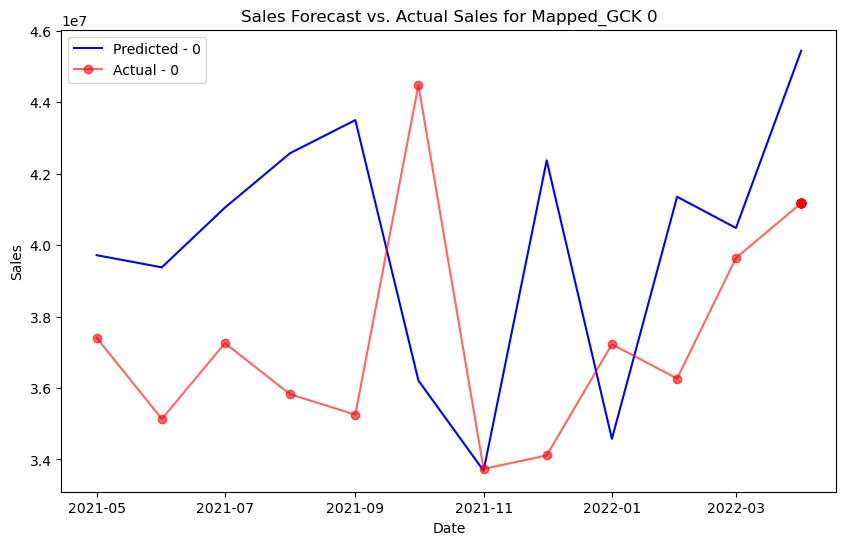

00:22:59 - cmdstanpy - INFO - Chain [1] start processing
00:22:59 - cmdstanpy - INFO - Chain [1] done processing


Training model for Mapped_GCK: 1


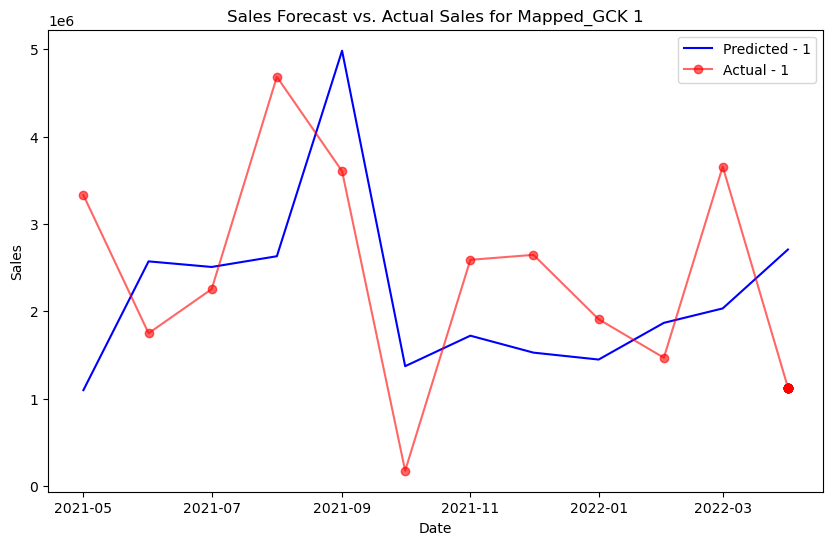

00:22:59 - cmdstanpy - INFO - Chain [1] start processing
00:22:59 - cmdstanpy - INFO - Chain [1] done processing


Training model for Mapped_GCK: 2


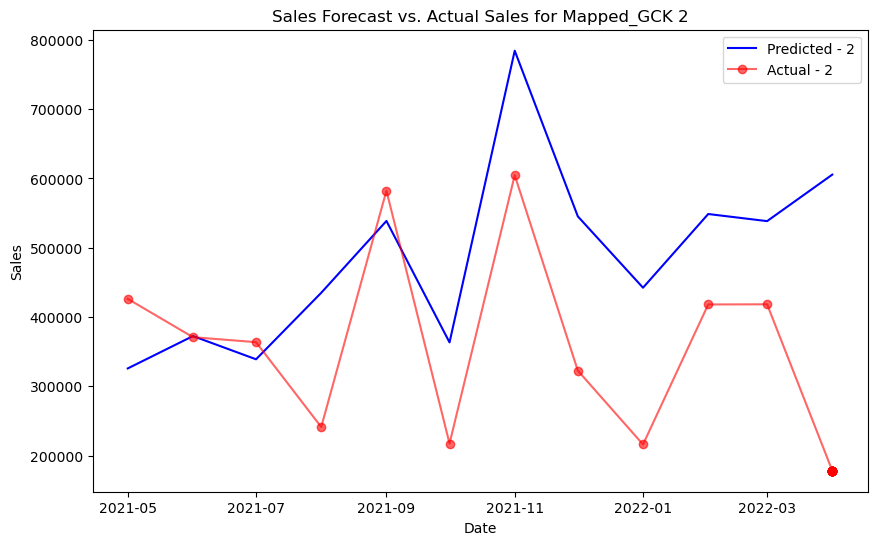

00:22:59 - cmdstanpy - INFO - Chain [1] start processing
00:22:59 - cmdstanpy - INFO - Chain [1] done processing


Training model for Mapped_GCK: 3


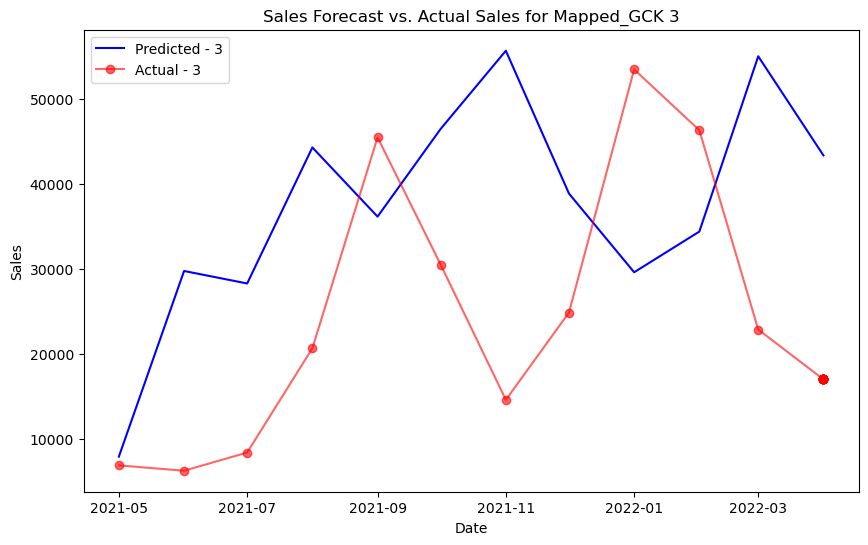

00:22:59 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 4


00:23:00 - cmdstanpy - INFO - Chain [1] done processing


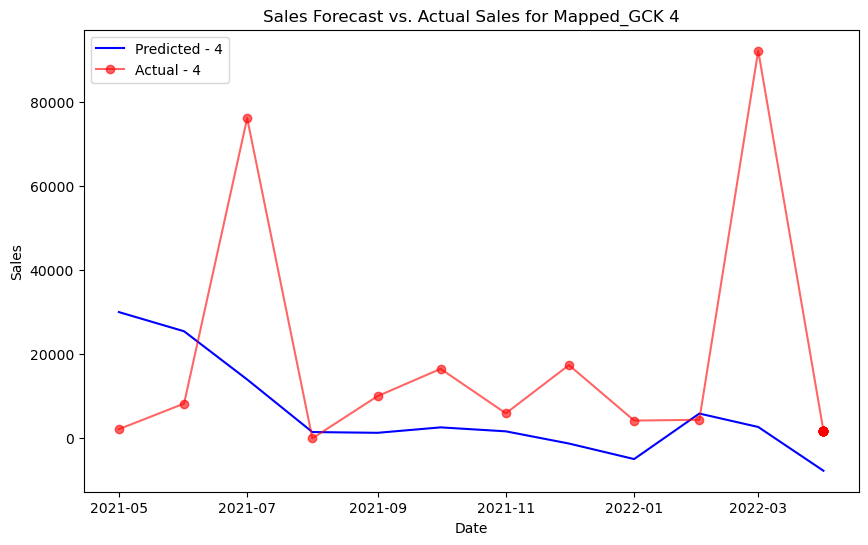

00:23:00 - cmdstanpy - INFO - Chain [1] start processing
00:23:00 - cmdstanpy - INFO - Chain [1] done processing


Training model for Mapped_GCK: 5


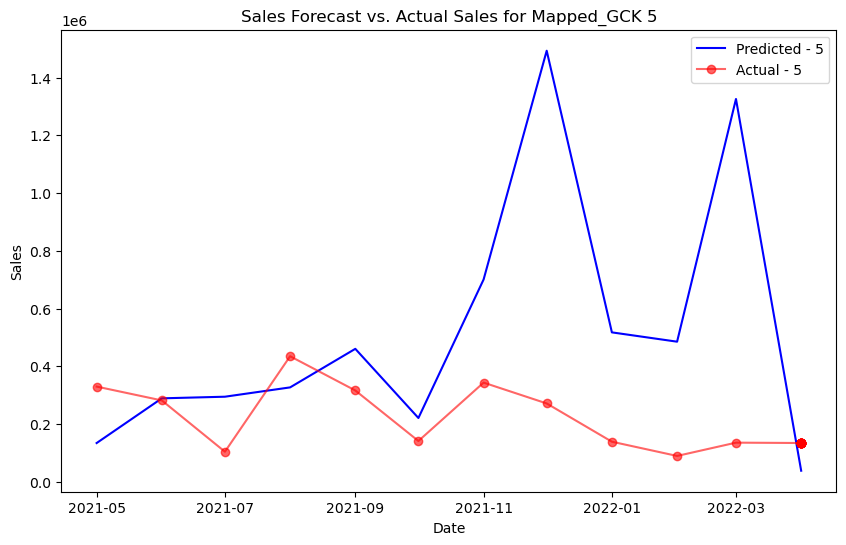

00:23:00 - cmdstanpy - INFO - Chain [1] start processing
00:23:00 - cmdstanpy - INFO - Chain [1] done processing


Training model for Mapped_GCK: 6


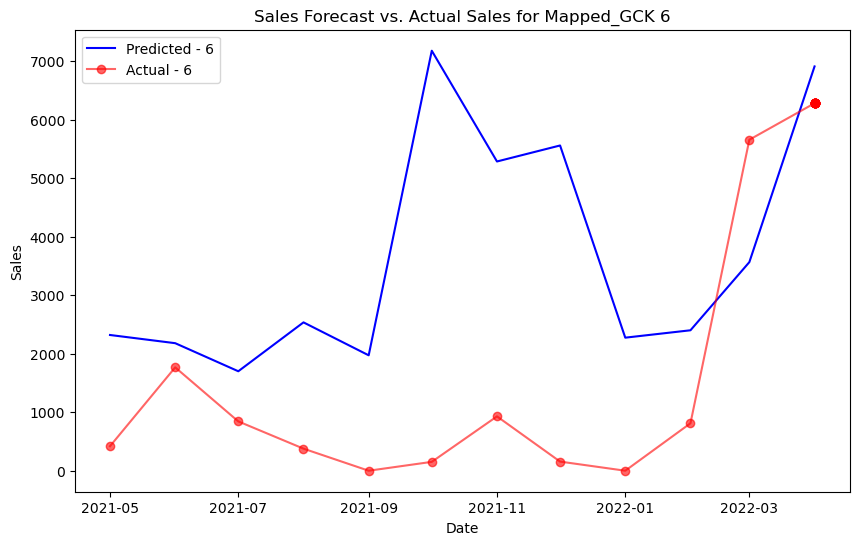

00:23:00 - cmdstanpy - INFO - Chain [1] start processing
00:23:00 - cmdstanpy - INFO - Chain [1] done processing


Training model for Mapped_GCK: 7


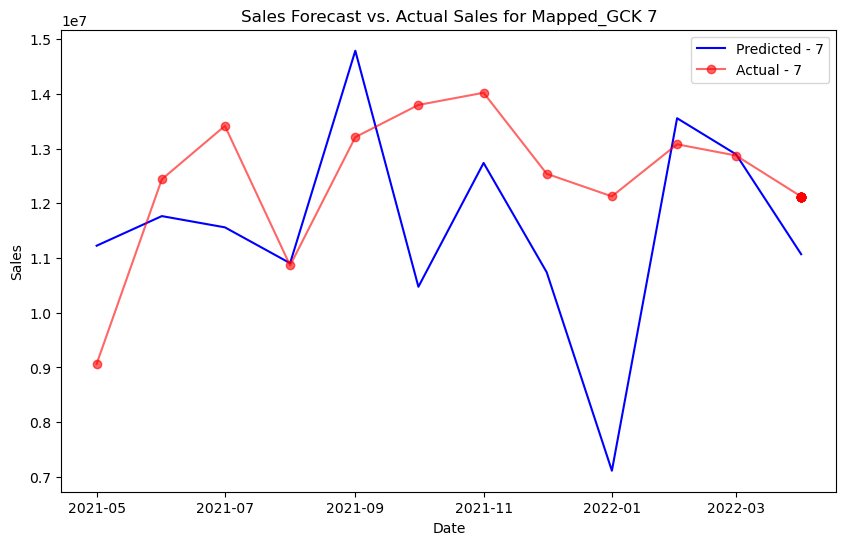

00:23:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 8


00:23:01 - cmdstanpy - INFO - Chain [1] done processing


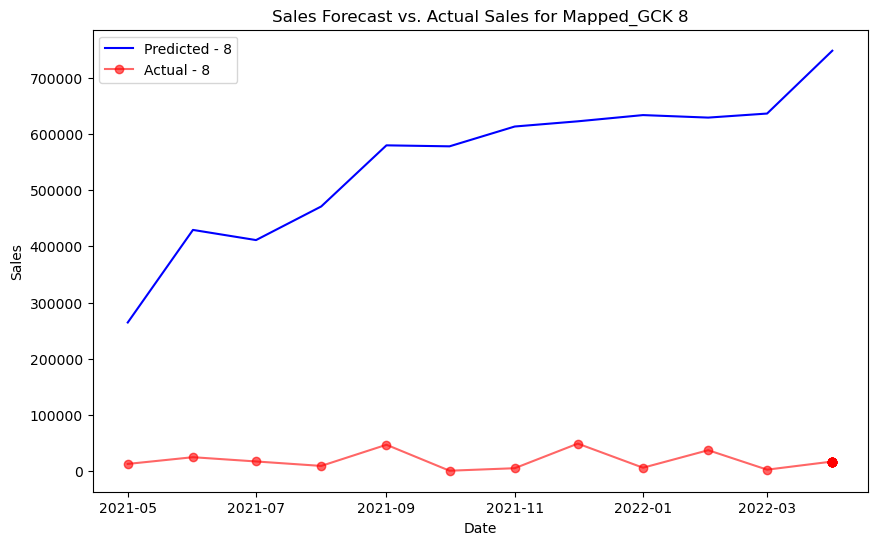

00:23:01 - cmdstanpy - INFO - Chain [1] start processing
00:23:01 - cmdstanpy - INFO - Chain [1] done processing


Training model for Mapped_GCK: 9


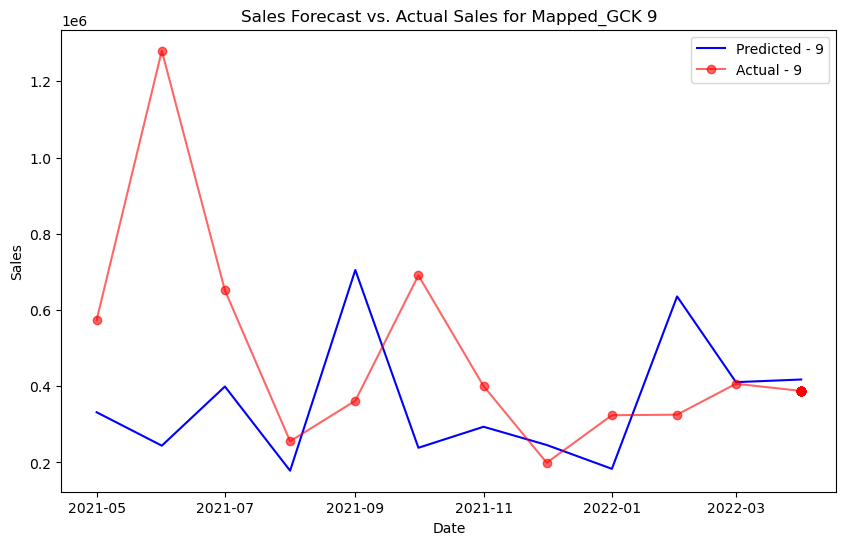

00:23:01 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 10


00:23:01 - cmdstanpy - INFO - Chain [1] done processing


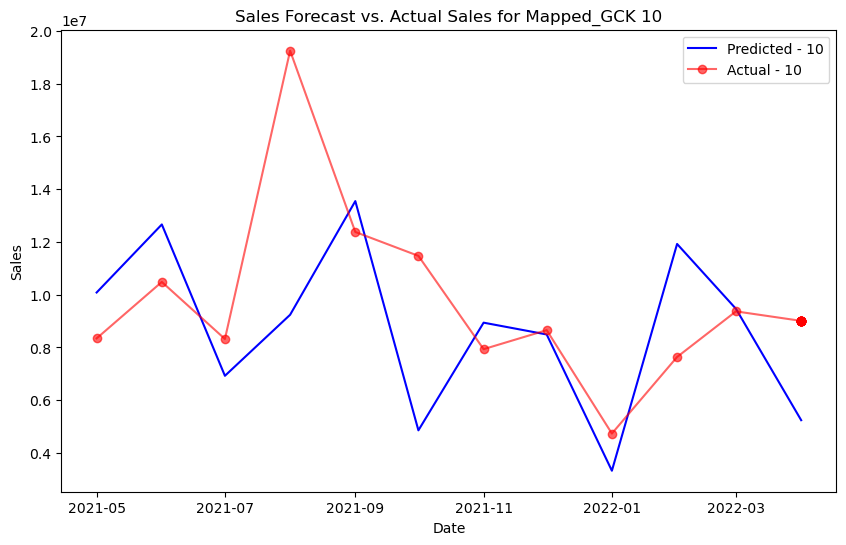

00:23:02 - cmdstanpy - INFO - Chain [1] start processing
00:23:02 - cmdstanpy - INFO - Chain [1] done processing


Training model for Mapped_GCK: 11


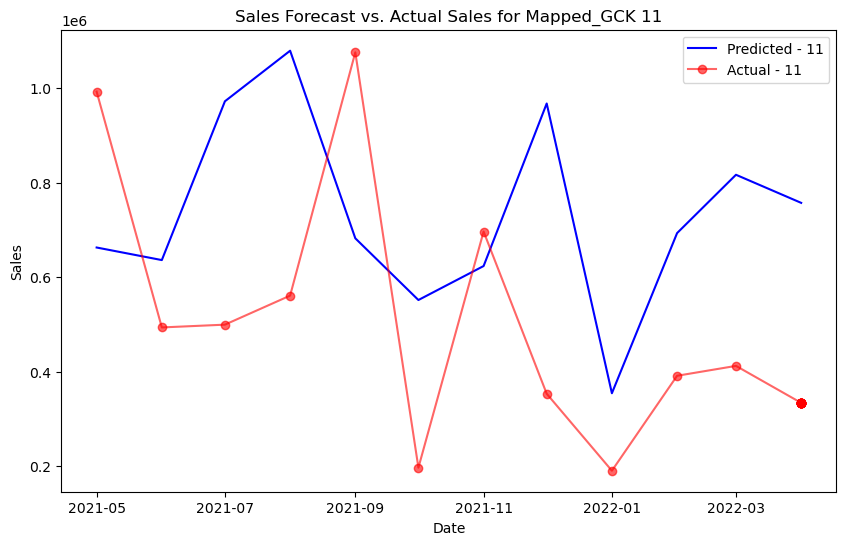

00:23:02 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 12


00:23:02 - cmdstanpy - INFO - Chain [1] done processing


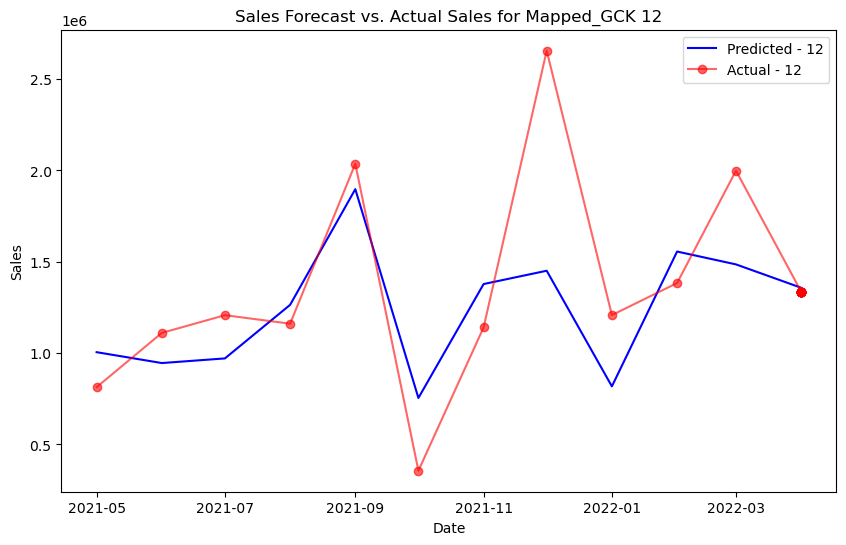

00:23:02 - cmdstanpy - INFO - Chain [1] start processing
00:23:02 - cmdstanpy - INFO - Chain [1] done processing


Training model for Mapped_GCK: 13


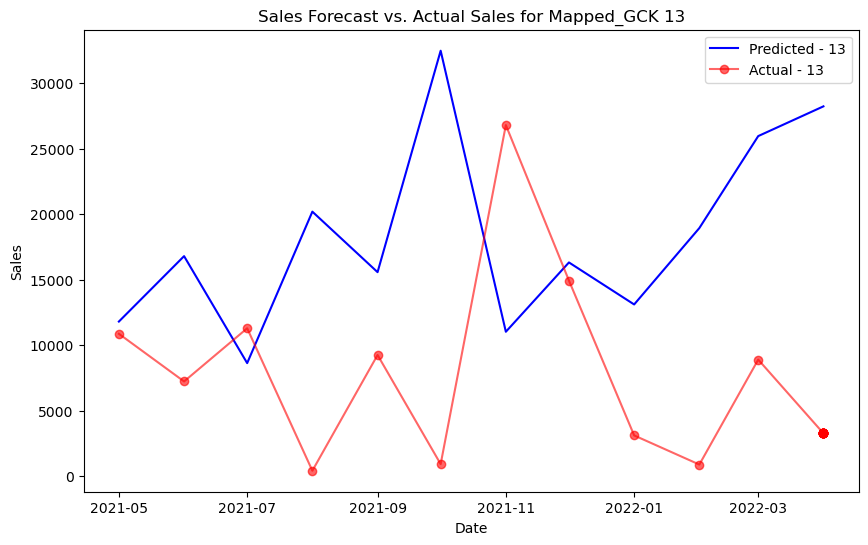

In [26]:
model_name = 'Prophet_vanila'

# Loop over each unique Mapped_GCK
for product in X_train['Mapped_GCK'].unique():
    print(f"Training model for Mapped_GCK: {product}")

    # Filter data for the current Mapped_GCK
    train_data = X_train[X_train['Mapped_GCK'] == product]
    test_data = X_test[X_test['Mapped_GCK'] == product]
    train_data['floor'] = 0
    train_data['cap'] = train_data['y'].max() * 1.5
    

    # Initialize Prophet model
    model = Prophet(growth='logistic')

    # Fit the model on training data
    model.fit(train_data)

    # Create future dataframe using test data
    future = test_data[['ds']].copy()
    future['floor'] = 0
    future['cap'] = train_data['y'].max() * 1.5

    # Predict sales
    forecast = model.predict(future)
    forecasts[product] = forecast  # Store results

    # Compute RMSE
    rmse = root_mean_squared_error(test_data['y'], forecast['yhat'])

    # Store RMSE in dictionary
    if product not in rmse_results:
        rmse_results[product] = {}  # Create entry if not exists
    rmse_results[product][model_name] = rmse  # Store RMSE for this model

    # Create a new figure for each product
    plt.figure(figsize=(10, 6))
    
    # Plot forecasted sales (yhat)
    plt.plot(forecast['ds'], forecast['yhat'], label=f'Predicted - {product}', color='blue')

    # Plot actual sales (from test data)
    plt.plot(test_data['ds'], test_data['y'], alpha=0.6, marker='o', label=f'Actual - {product}', color='red')

    # Finalize the plot
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Sales Forecast vs. Actual Sales for Mapped_GCK {product}')
    plt.legend()
    plt.show()

# Convert dictionary to DataFrame
rmse_df = pd.DataFrame.from_dict(rmse_results, orient='index')

In [27]:
# for product in X_train['Mapped_GCK'].unique():
    
#     plt.plot(forecast['ds'], forecast['yhat'], label=f'Product {product}')

# plt.xlabel('Date')
# plt.ylabel('Sales')
# plt.title('Global Sales Forecast for All Products')
# plt.legend()  # Show product labels
# plt.show()

Prophet with features

00:23:03 - cmdstanpy - INFO - Chain [1] start processing
00:23:03 - cmdstanpy - INFO - Chain [1] done processing


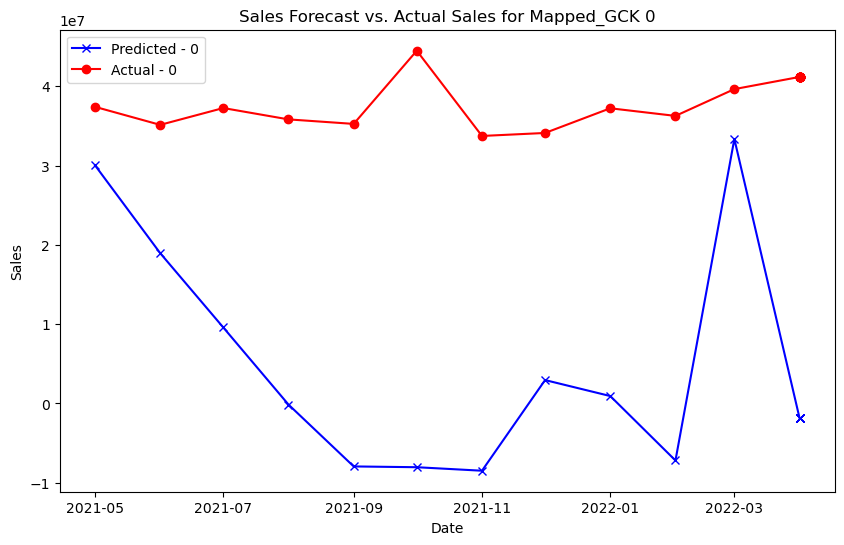

00:23:03 - cmdstanpy - INFO - Chain [1] start processing
00:23:03 - cmdstanpy - INFO - Chain [1] done processing


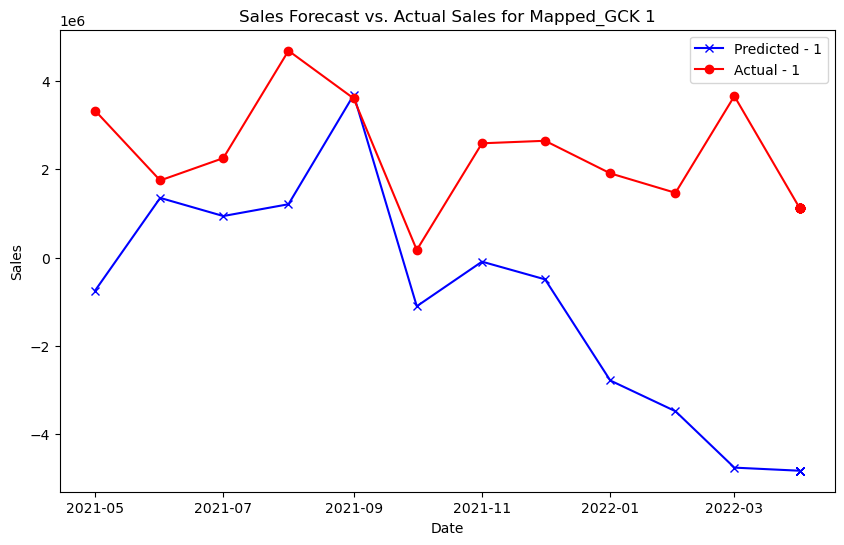

00:23:03 - cmdstanpy - INFO - Chain [1] start processing
00:23:04 - cmdstanpy - INFO - Chain [1] done processing


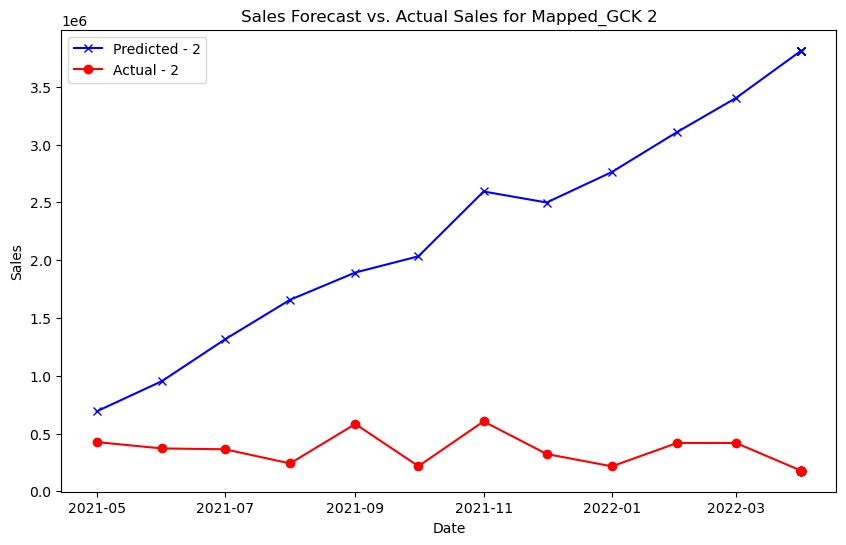

00:23:04 - cmdstanpy - INFO - Chain [1] start processing
00:23:04 - cmdstanpy - INFO - Chain [1] done processing


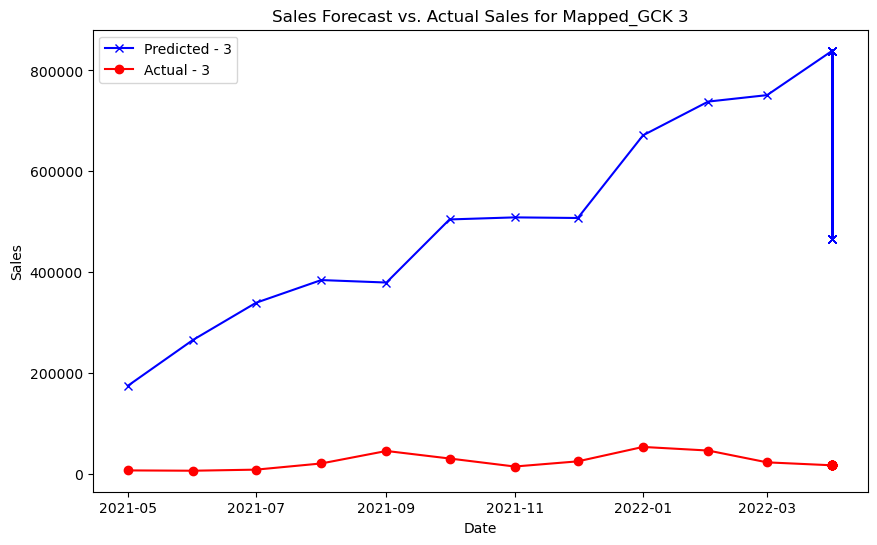

00:23:04 - cmdstanpy - INFO - Chain [1] start processing
00:23:04 - cmdstanpy - INFO - Chain [1] done processing


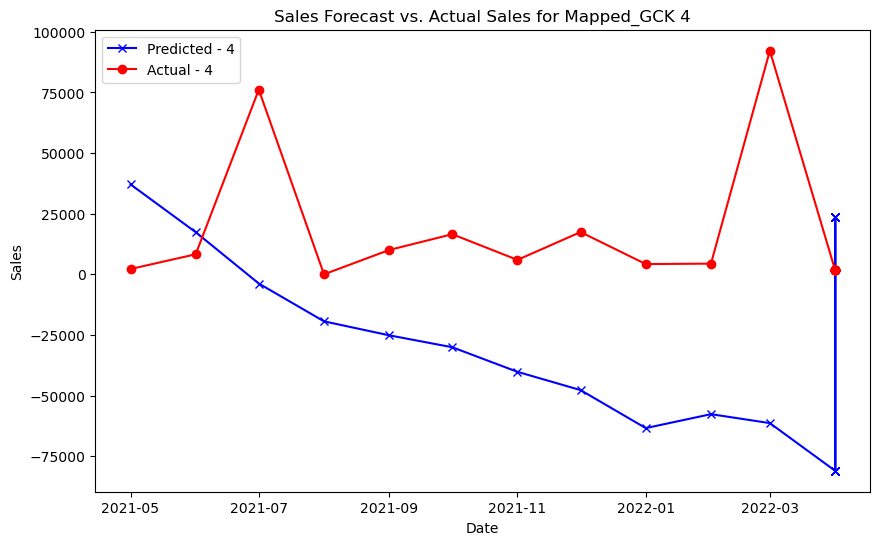

00:23:04 - cmdstanpy - INFO - Chain [1] start processing
00:23:05 - cmdstanpy - INFO - Chain [1] done processing


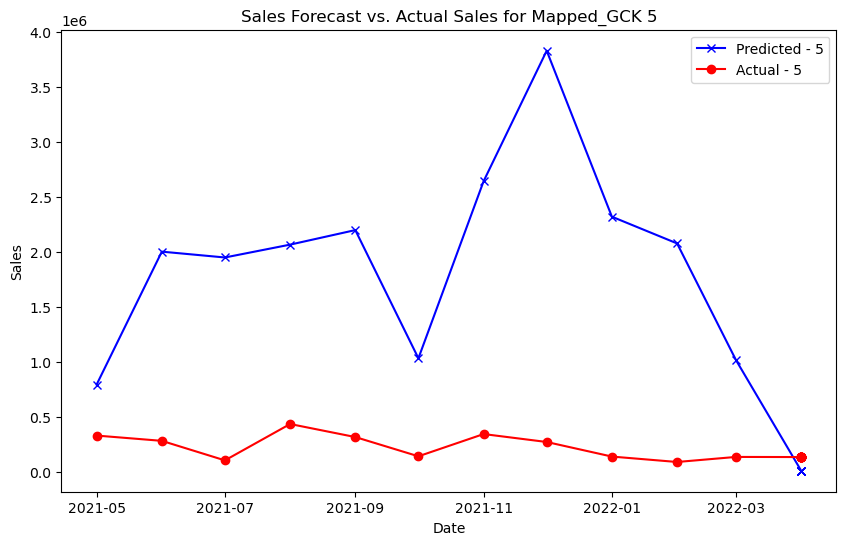

00:23:05 - cmdstanpy - INFO - Chain [1] start processing
00:23:05 - cmdstanpy - INFO - Chain [1] done processing


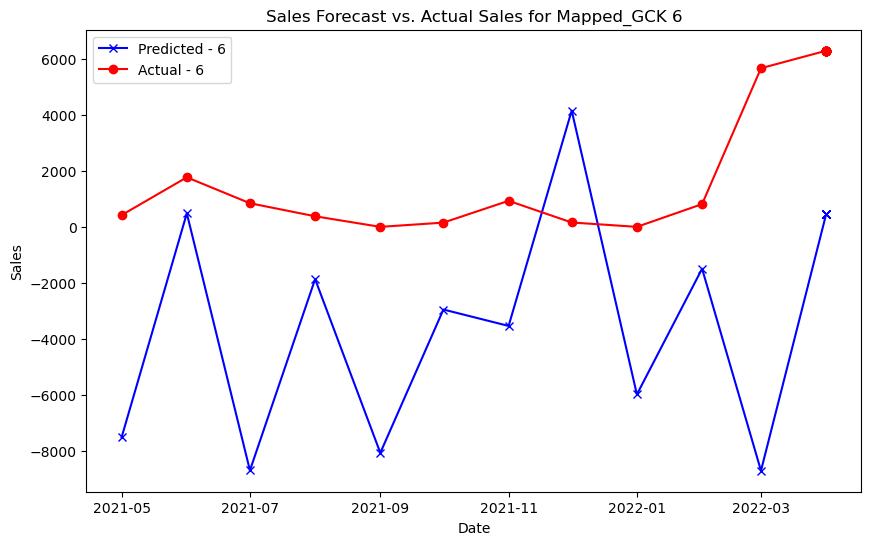

00:23:05 - cmdstanpy - INFO - Chain [1] start processing
00:23:05 - cmdstanpy - INFO - Chain [1] done processing


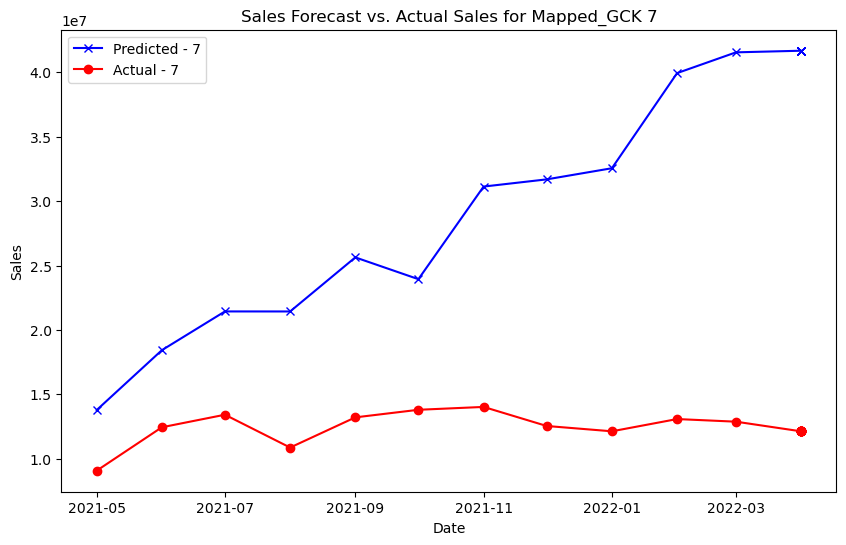

00:23:05 - cmdstanpy - INFO - Chain [1] start processing
00:23:06 - cmdstanpy - INFO - Chain [1] done processing


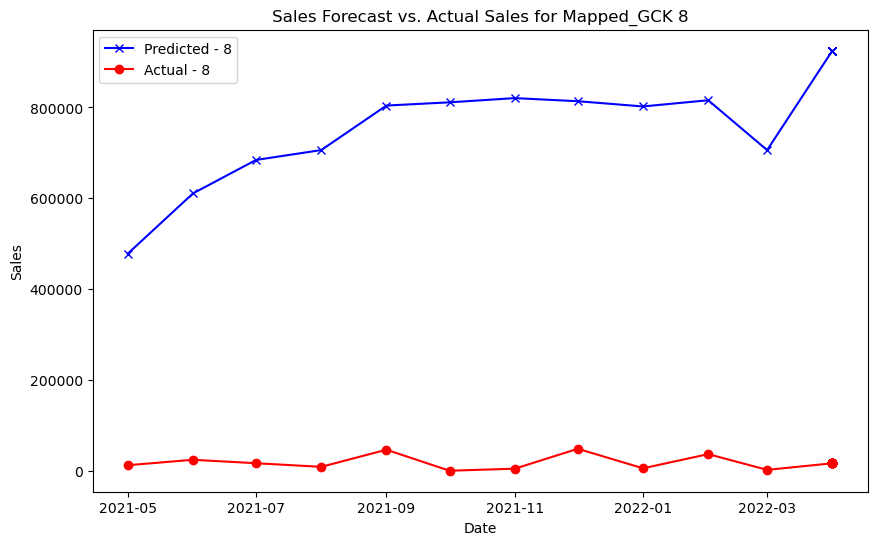

00:23:06 - cmdstanpy - INFO - Chain [1] start processing
00:23:06 - cmdstanpy - INFO - Chain [1] done processing


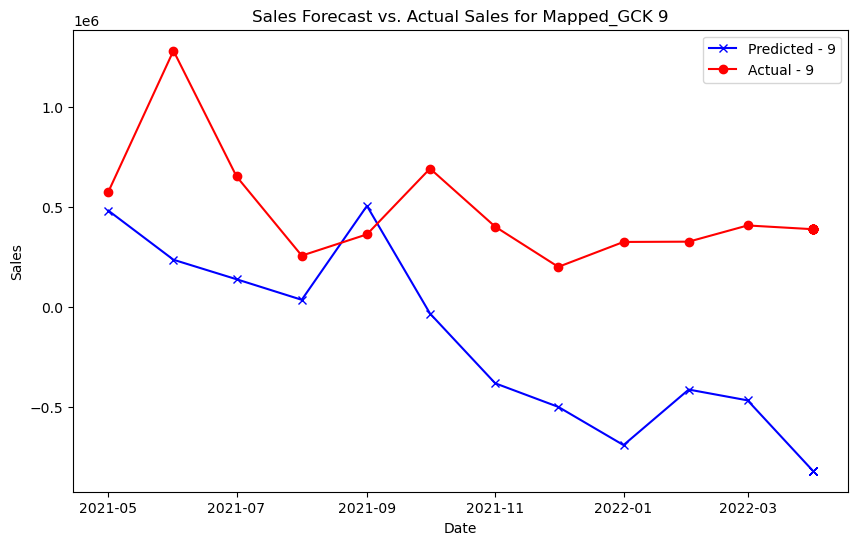

00:23:06 - cmdstanpy - INFO - Chain [1] start processing
00:23:06 - cmdstanpy - INFO - Chain [1] done processing


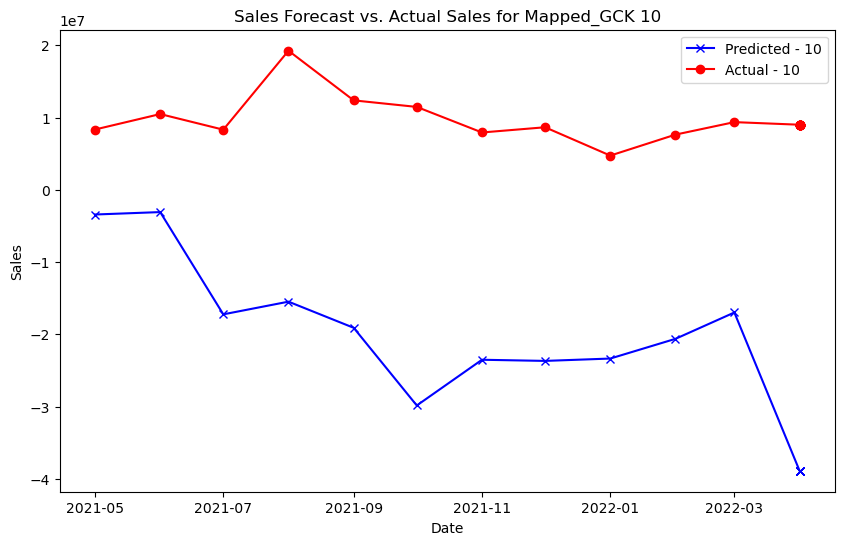

00:23:07 - cmdstanpy - INFO - Chain [1] start processing
00:23:07 - cmdstanpy - INFO - Chain [1] done processing


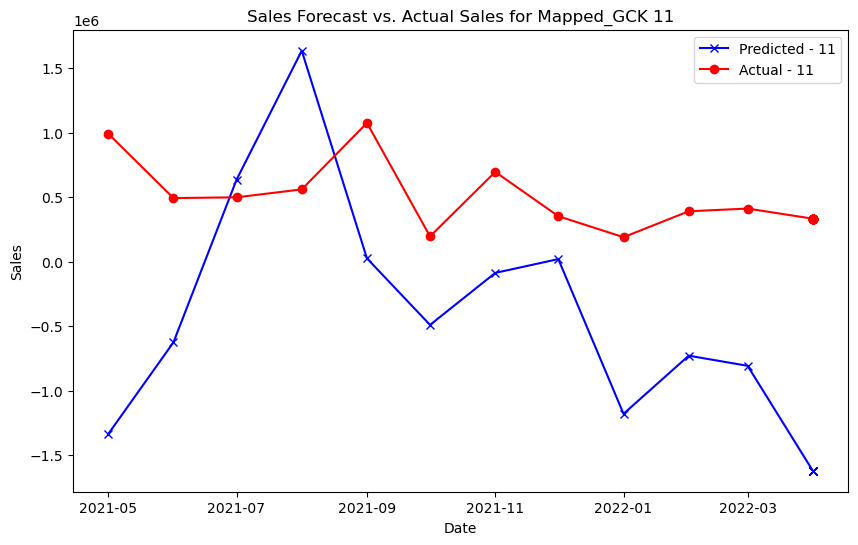

00:23:07 - cmdstanpy - INFO - Chain [1] start processing
00:23:07 - cmdstanpy - INFO - Chain [1] done processing


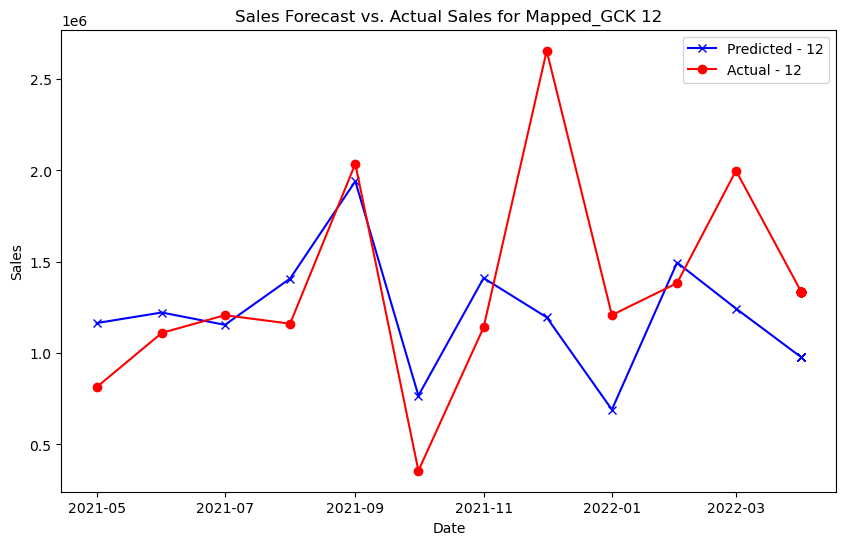

00:23:07 - cmdstanpy - INFO - Chain [1] start processing
00:23:08 - cmdstanpy - INFO - Chain [1] done processing


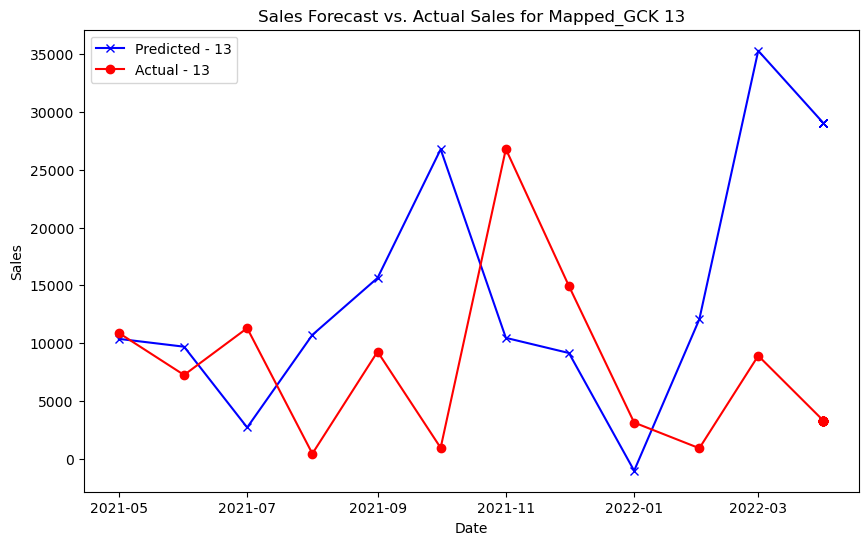

In [28]:
model_name = "Prophet_with_features"
forecasts = {}

# Loop over each unique Mapped_GCK
for product in X_train['Mapped_GCK'].unique():
    
    # Select the top 10 features for the current product
    top_features = top_features_per_product.get(product, [])  # Get saved features
    
    train_data = X_train[X_train['Mapped_GCK'] == product][['ds', 'y'] + top_features]
    test_data = X_test[X_test['Mapped_GCK'] == product][['ds', 'y'] + top_features]
    train_data[top_features] = train_data[top_features].astype(float)
    test_data[top_features] = test_data[top_features].astype(float)
    train_data['floor'] = 0.5
    train_data['cap'] = train_data['y'].max() * 1.5

    # Initialize Prophet model
    model = Prophet(growth='logistic')
    
    # Add each top feature as a regressor
    for feature in top_features:
        model.add_regressor(feature)
    
    # Fit the model on training data
    model.fit(train_data)

    # Create future dataframe using test data
    future = test_data[['ds']].copy()
    for feature in top_features:
        future[feature] = test_data[feature].values  
    future['floor'] = 0.5
    future['cap'] = train_data['y'].max() * 1.5
    
    # Predict sales
    forecast = model.predict(future)
    forecasts[product] = forecast  

    # Compute RMSE
    rmse = root_mean_squared_error(test_data['y'], forecast['yhat'])

    # Store RMSE in dictionary
    if product not in rmse_results:
        rmse_results[product] = {}  # Create entry if not exists
    rmse_results[product][model_name] = rmse  # Store RMSE for this model

    # Create a new figure for each product
    plt.figure(figsize=(10, 6))
    
    # Plot forecasted sales (yhat)
    plt.plot(forecast['ds'], forecast['yhat'], marker='x', label=f'Predicted - {product}', color='blue')

    # Plot actual sales (from test data)
    plt.plot(test_data['ds'], test_data['y'], marker='o', label=f'Actual - {product}', color='red')

    # Finalize the plot
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Sales Forecast vs. Actual Sales for Mapped_GCK {product}')
    plt.legend()
    plt.show()

# Convert dictionary to DataFrame
rmse_df = pd.DataFrame.from_dict(rmse_results, orient='index')

In [29]:
rmse_results

{0: {'Prophet_vanila': 4765012.155207862,
  'Prophet_with_features': 39722658.04398702},
 1: {'Prophet_vanila': 1469030.5677702597,
  'Prophet_with_features': 5209426.855683226},
 2: {'Prophet_vanila': 342064.54343881964,
  'Prophet_with_features': 3048698.324498198},
 3: {'Prophet_vanila': 24759.261680468364,
  'Prophet_with_features': 595198.7118918371},
 4: {'Prophet_vanila': 23669.71699364573,
  'Prophet_with_features': 63394.6254593793},
 5: {'Prophet_vanila': 365113.55770673166,
  'Prophet_with_features': 1236273.1095607083},
 6: {'Prophet_vanila': 2186.0770976954177,
  'Prophet_with_features': 6266.473617511534},
 7: {'Prophet_vanila': 1611361.8425465007,
  'Prophet_with_features': 25160368.73947699},
 8: {'Prophet_vanila': 655836.5526712933,
  'Prophet_with_features': 836543.772044151},
 9: {'Prophet_vanila': 248629.69589122635,
  'Prophet_with_features': 1032164.0950728189},
 10: {'Prophet_vanila': 3864614.5255110743,
  'Prophet_with_features': 41223670.31081627},
 11: {'Proph

## XGBoost

Without features

With features

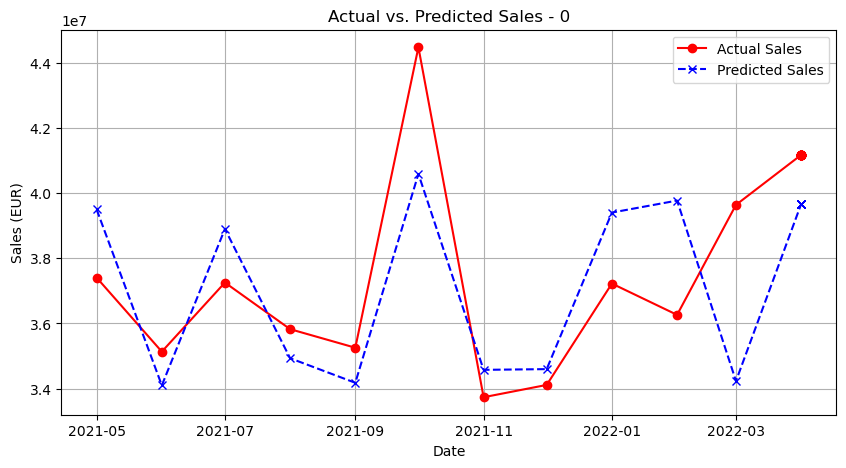

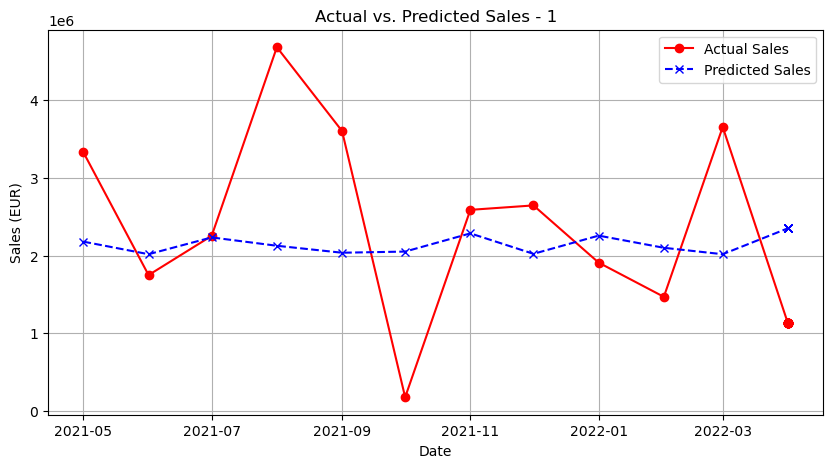

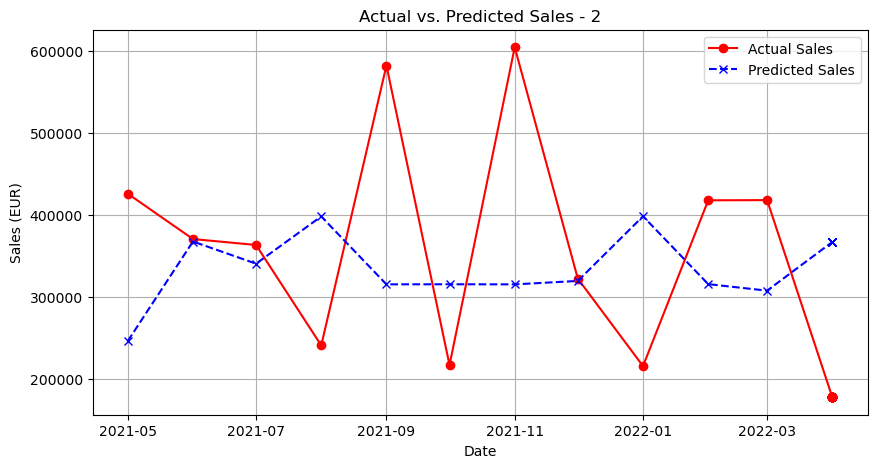

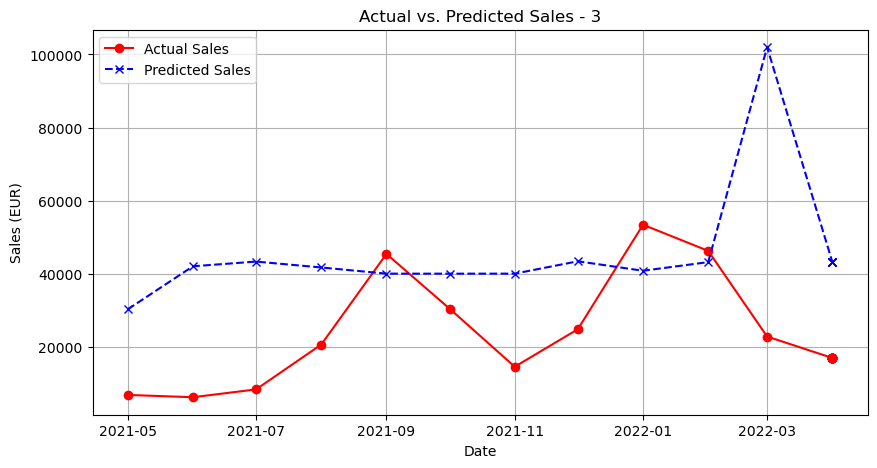

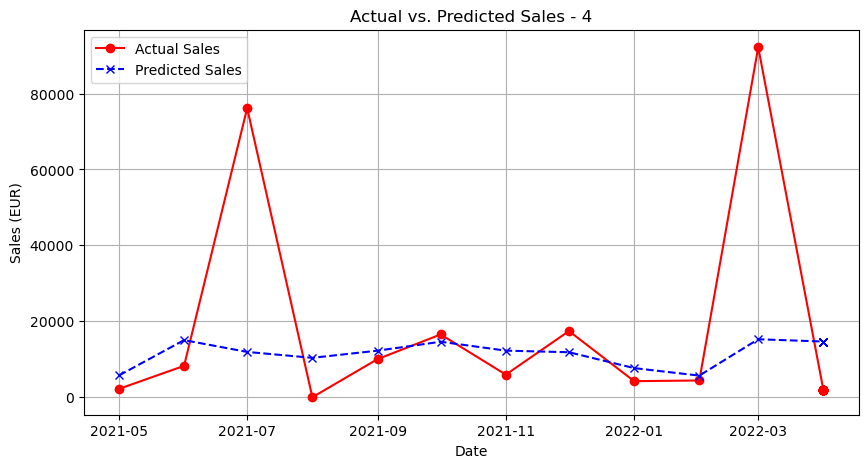

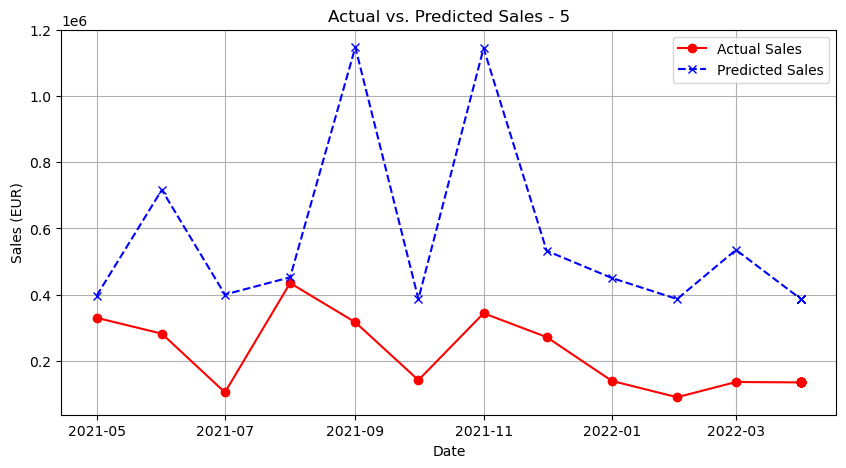

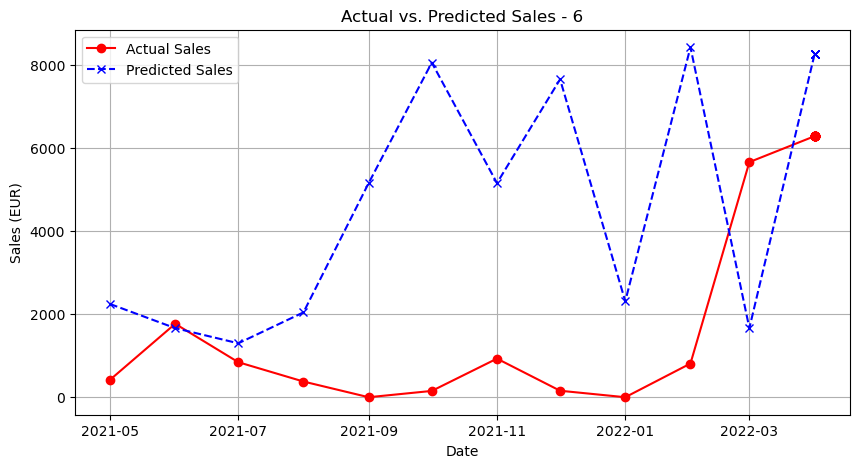

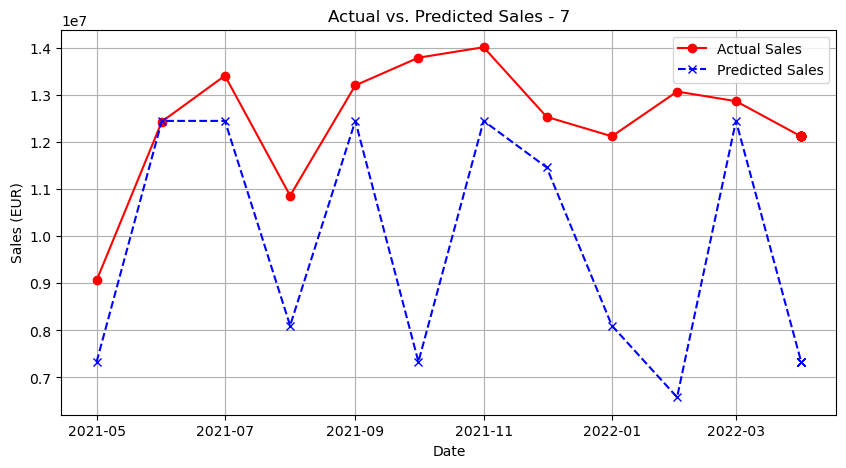

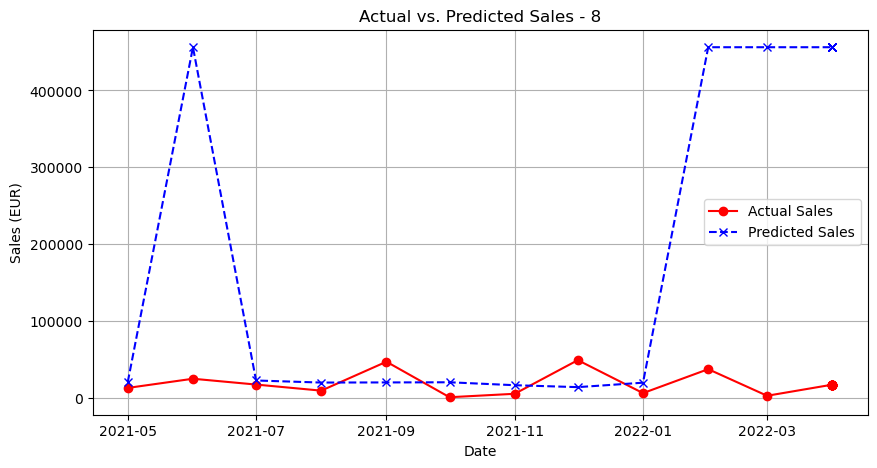

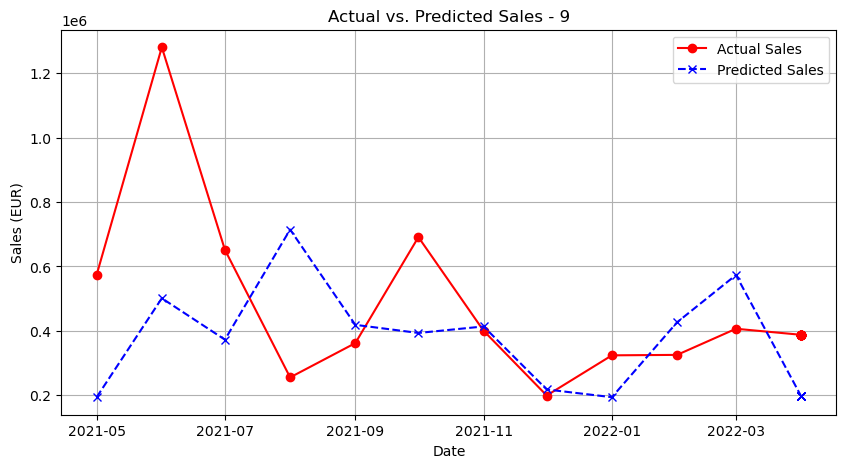

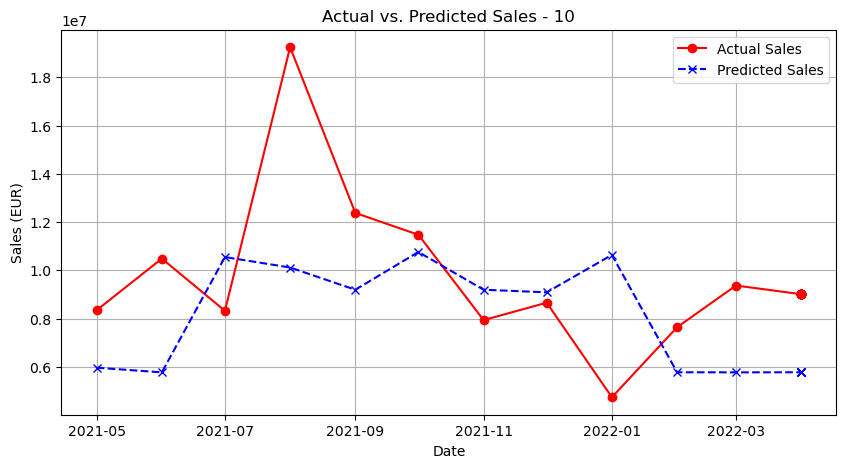

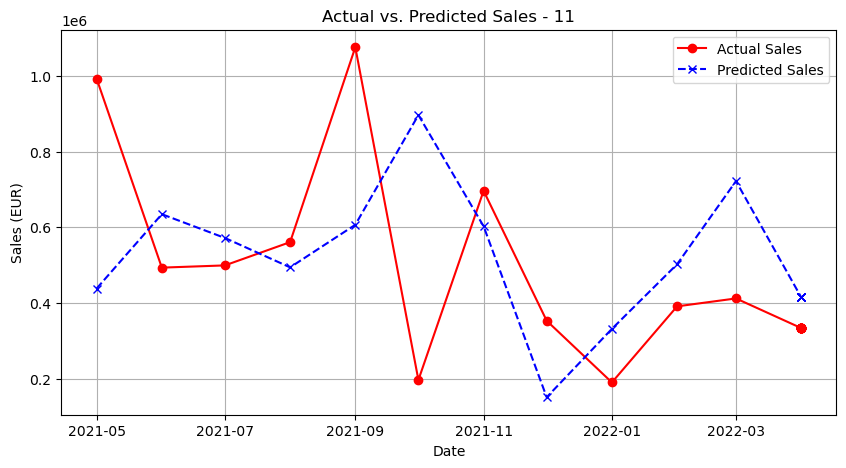

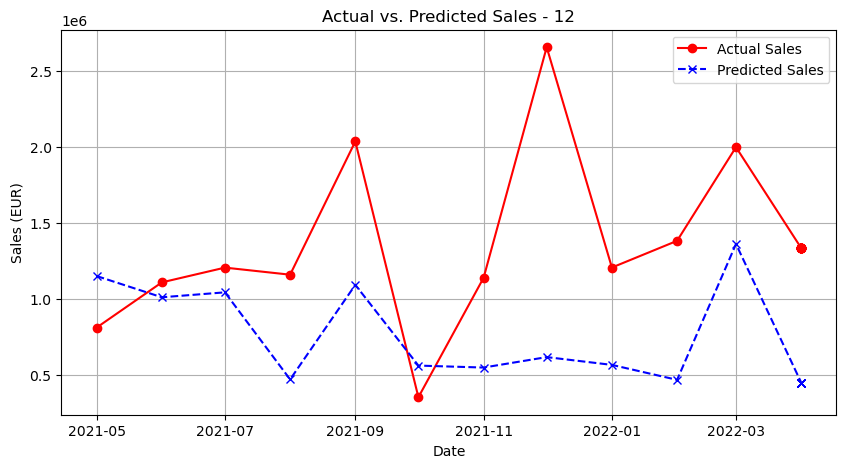

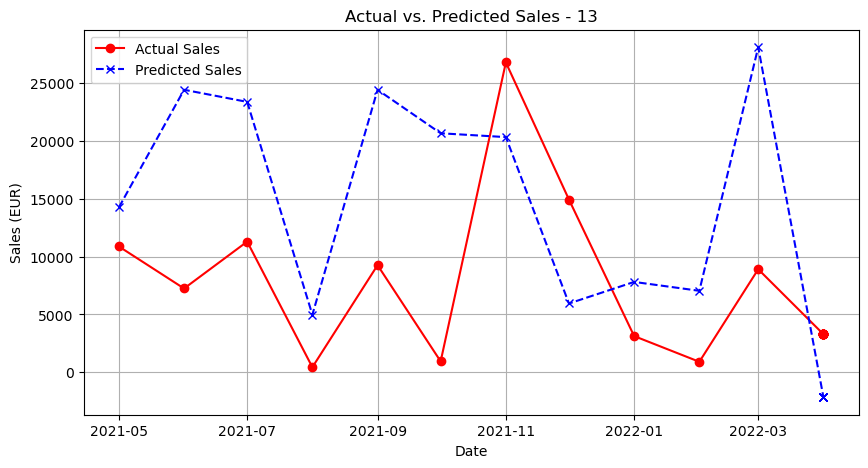

In [30]:
model_name = "XGBoost"
forecast = {}


for product in df['Mapped_GCK'].unique():
    product_df = df[df['Mapped_GCK'] == product]
    df_train = product_df[product_df['date'] < '2021-05-01']
    df_test = product_df[product_df['date'] >= '2021-05-01']
    
    # Use only the selected top features for this product
    top_features = top_features_per_product.get(product, [])
    
    X_train = df_train[top_features]
    y_train = df_train['Sales_EUR']
    X_test = df_test[top_features]
    y_test = df_test['Sales_EUR']
    
    # Train XGBoost model with selected features
    model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric="rmse", n_estimators=100, random_state=1)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Store predictions
    forecast[product] = y_pred
    
    # Calculate RMSE
    rmse = root_mean_squared_error(y_test, y_pred)
    
    # Store RMSE under the model name
    if product not in rmse_results:
        rmse_results[product] = {}  # Create entry if not exists
    rmse_results[product][model_name] = rmse  # Store RMSE for this model
    
    plt.figure(figsize=(10, 5))
    plt.plot(df_test['date'], y_test, label="Actual Sales", marker="o", color = 'red')
    plt.plot(df_test['date'], y_pred, label="Predicted Sales", linestyle="dashed", marker="x" , color = 'blue')
    plt.xlabel("Date")
    plt.ylabel("Sales (EUR)")
    plt.title(f"Actual vs. Predicted Sales - {product}")
    plt.legend()
    plt.grid()
    plt.show()


XGBoost with grid search

In [31]:
model_name = "XGBoost_with_GridSearch"
grid_search_results = {}

param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [3, 5, 7, 6],            
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 1.0]          
}

for product in df['Mapped_GCK'].unique():
    product_df = df[df['Mapped_GCK'] == product]
    df_train = product_df[product_df['date'] < '2021-05-01']
    df_test = product_df[product_df['date'] >= '2021-05-01']
    
    # Use only the selected top features for this product
    top_features = top_features_per_product.get(product, [])
    
    X_train = df_train[top_features]
    y_train = df_train['Sales_EUR']
    
    # Perform Grid Search
    model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric="rmse", random_state=1)
    grid_search = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Get best parameters and RMSE
    best_params = grid_search.best_params_
    best_rmse = -grid_search.best_score_
    
    # Store best parameters and RMSE for each product
    grid_search_results[product] = {'best_rmse': best_rmse, 'best_params': best_params}


In [32]:
grid_search_results

{0: {'best_rmse': 7060565.138749753,
  'best_params': {'learning_rate': 0.01,
   'max_depth': 3,
   'n_estimators': 200,
   'subsample': 0.8}},
 1: {'best_rmse': 1307760.3663299056,
  'best_params': {'learning_rate': 0.01,
   'max_depth': 6,
   'n_estimators': 50,
   'subsample': 0.8}},
 2: {'best_rmse': 242613.97853622644,
  'best_params': {'learning_rate': 0.01,
   'max_depth': 3,
   'n_estimators': 50,
   'subsample': 0.8}},
 3: {'best_rmse': 26208.96476386081,
  'best_params': {'learning_rate': 0.01,
   'max_depth': 5,
   'n_estimators': 50,
   'subsample': 0.8}},
 4: {'best_rmse': 12286.950441908704,
  'best_params': {'learning_rate': 0.01,
   'max_depth': 3,
   'n_estimators': 100,
   'subsample': 1.0}},
 5: {'best_rmse': 619658.7973562416,
  'best_params': {'learning_rate': 0.3,
   'max_depth': 3,
   'n_estimators': 200,
   'subsample': 1.0}},
 6: {'best_rmse': 2307.0781005258054,
  'best_params': {'learning_rate': 0.2,
   'max_depth': 3,
   'n_estimators': 50,
   'subsample': 0

In [33]:
model_name = "XGBoost_with_GridSearch"
forecast = {}

for product in df['Mapped_GCK'].unique():
    product_df = df[df['Mapped_GCK'] == product]
    df_train = product_df[product_df['date'] < '2021-05-01']
    df_test = product_df[product_df['date'] >= '2021-05-01']
    
    # Use only the selected top features for this product
    top_features = top_features_per_product.get(product, [])
    
    X_train = df_train[top_features]
    y_train = df_train['Sales_EUR']
    X_test = df_test[top_features]
    y_test = df_test['Sales_EUR']
    
    # Retrieve best parameters from grid search results
    best_params = grid_search_results.get(product, {}).get(model_name, {}).get('best_params', {})
    
    # Train final model with best parameters
    final_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric="rmse", 
                                   **best_params, random_state=1)
    final_model.fit(X_train, y_train)
    
    # Make predictions with final model
    final_y_pred = final_model.predict(X_test)
    final_rmse = root_mean_squared_error(y_test, final_y_pred)
    
    # Store final model results in rmse_results
    if product not in rmse_results:
        rmse_results[product] = {}
    rmse_results[product][model_name] = final_rmse
    
    # Store final predictions
    forecast[product] = final_y_pred


In [34]:
rmse_results

{0: {'Prophet_vanila': 4765012.155207862,
  'Prophet_with_features': 39722658.04398702,
  'XGBoost': 2008353.3100930313,
  'XGBoost_with_GridSearch': 2008353.3100930313},
 1: {'Prophet_vanila': 1469030.5677702597,
  'Prophet_with_features': 5209426.855683226,
  'XGBoost': 1241389.066081013,
  'XGBoost_with_GridSearch': 1241389.066081013},
 2: {'Prophet_vanila': 342064.54343881964,
  'Prophet_with_features': 3048698.324498198,
  'XGBoost': 177492.00781092848,
  'XGBoost_with_GridSearch': 177492.00781092848},
 3: {'Prophet_vanila': 24759.261680468364,
  'Prophet_with_features': 595198.7118918371,
  'XGBoost': 28602.165918937244,
  'XGBoost_with_GridSearch': 28602.165918937244},
 4: {'Prophet_vanila': 23669.71699364573,
  'Prophet_with_features': 63394.6254593793,
  'XGBoost': 21884.306738913747,
  'XGBoost_with_GridSearch': 21884.306738913747},
 5: {'Prophet_vanila': 365113.55770673166,
  'Prophet_with_features': 1236273.1095607083,
  'XGBoost': 339028.86545673665,
  'XGBoost_with_GridSe

## Linear Regression

Without features

With features

In [35]:
df_model.dtypes

Mapped_GCK                         int32
Sales_EUR                        float64
date                      datetime64[ns]
MAB_ELE_PRO156                   float64
MAB_ELE_SHP156                   float64
MAB_ELE_PRO250                   float64
MAB_ELE_SHP250                   float64
MAB_ELE_PRO276                   float64
MAB_ELE_SHP276                   float64
MAB_ELE_PRO380                   float64
MAB_ELE_SHP380                   float64
MAB_ELE_PRO392                   float64
MAB_ELE_SHP392                   float64
MAB_ELE_PRO756                   float64
MAB_ELE_SHP756                   float64
MAB_ELE_PRO826                   float64
MAB_ELE_SHP826                   float64
MAB_ELE_PRO840                   float64
MAB_ELE_SHP840                   float64
MAB_ELE_PRO1100                  float64
MAB_ELE_SHP1100                  float64
RohiBASEMET1000_org              float64
RohiENERGY1000_org               float64
RohiMETMIN1000_org               float64
RohiNATGAS1000_o

In [36]:
model_name = "Linear_Regression_with_features"
forecasts = {}

for product in X_train['Mapped_GCK'].unique():
    
    # Select the top 10 features for the current product
    top_features = top_features_per_product.get(product, [])  # Get saved features
    
    # Filter training and test data based on the product
    train_data = X_train[X_train['Mapped_GCK'] == product][['ds'] + top_features]
    test_data = X_test[X_test['Mapped_GCK'] == product][['ds'] + top_features]

    # Align y_train and y_test indices with X_train and X_test
    y_train_product = y_train.loc[train_data.index]
    y_test_product = y_test.loc[test_data.index]
    
    # Ensure features are floats
    train_data[top_features] = train_data[top_features].astype(float)
    test_data[top_features] = test_data[top_features].astype(float)

    # Train Linear Regression model
    model = LinearRegression()
    model.fit(train_data[top_features], y_train_product)  

    # Make predictions
    forecast = model.predict(test_data[top_features])
    
    # Store predictions
    forecasts[product] = forecast  

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_test_product, forecast))

    # Store RMSE in dictionary
    if product not in rmse_results:
        rmse_results[product] = {}  # Create entry if not exists
    rmse_results[product][model_name] = rmse  # Store RMSE for this model

    # Create a new figure for each product
    plt.figure(figsize=(10, 6))
    
    # Plot forecasted sales
    plt.plot(test_data['ds'], forecast, marker='x', label=f'Predicted - {product}', color='blue')

    # Plot actual sales
    plt.plot(test_data['ds'], y_test_product, marker='o', label=f'Actual - {product}', color='red')

    # Finalize the plot
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Sales Forecast vs. Actual Sales for Mapped_GCK {product}')
    plt.legend()
    plt.show()

# Convert RMSE dictionary to DataFrame
rmse_df = pd.DataFrame.from_dict(rmse_results, orient='index')

KeyError: 'Mapped_GCK'